## Carda Bibliotecas

In [1]:
import rioxarray
import xarray
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import geopandas as gpd
from datetime import datetime
import matplotlib.pyplot as plt
import  os
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

## **Xarray para leer archivos NetCDF y  GeoTiff** 

In [2]:
dmw =  xarray.open_dataset("datos/AWS/OR_ABI-L2-DMWF-M6C02_G16_s20241131900204_e20241131909512_c20241131922214.nc")

In [3]:
C13_lb1 = xarray.open_dataset("datos/LANOT/goes16.abi-2024.0422.1900-C13_2km.tif",engine="rasterio")

/home/dulce/mambaforge/envs/sat/lib/python3.12/site-packages/rioxarray/xarray_plugin.py:58: SerializationWarning: variable 'Rad' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  rds = _io.open_rasterio(


## **Preprocesamiento**

In [4]:
radiance=C13_lb1.Rad.sel(band=1).values
bounds = (C13_lb1.x.data[0],C13_lb1.x.data[-1], C13_lb1.y.data[-1], C13_lb1.y.data[0])

In [5]:
fk1=1.07364e+04
fk2=1.38986e+03
bc1=0.13445
bc2=0.99955

In [6]:
T=fk2/(np.log((fk1/radiance)+1))
ir_BT=(bc2*T+bc1)-273

In [7]:
croped=dmw.where((dmw.lon >= bounds[0]) & (dmw.lon <= bounds[1]) & (dmw.lat >= bounds[2]) & (dmw.lat <= bounds[3]))
croped['wind_direction']-=180
u = croped.wind_speed * np.sin(croped.wind_direction * np.pi/180)
v = croped.wind_speed * np.cos(croped.wind_direction * np.pi/180)

## **Uso de Matplotlib para graficación**

In [8]:
gdf = gpd.read_file('datos/capas/destdv1gw.shp')

Text(0.43, 0.95, 'Dirección de viento 22/04/2024, 19:00 UTC')

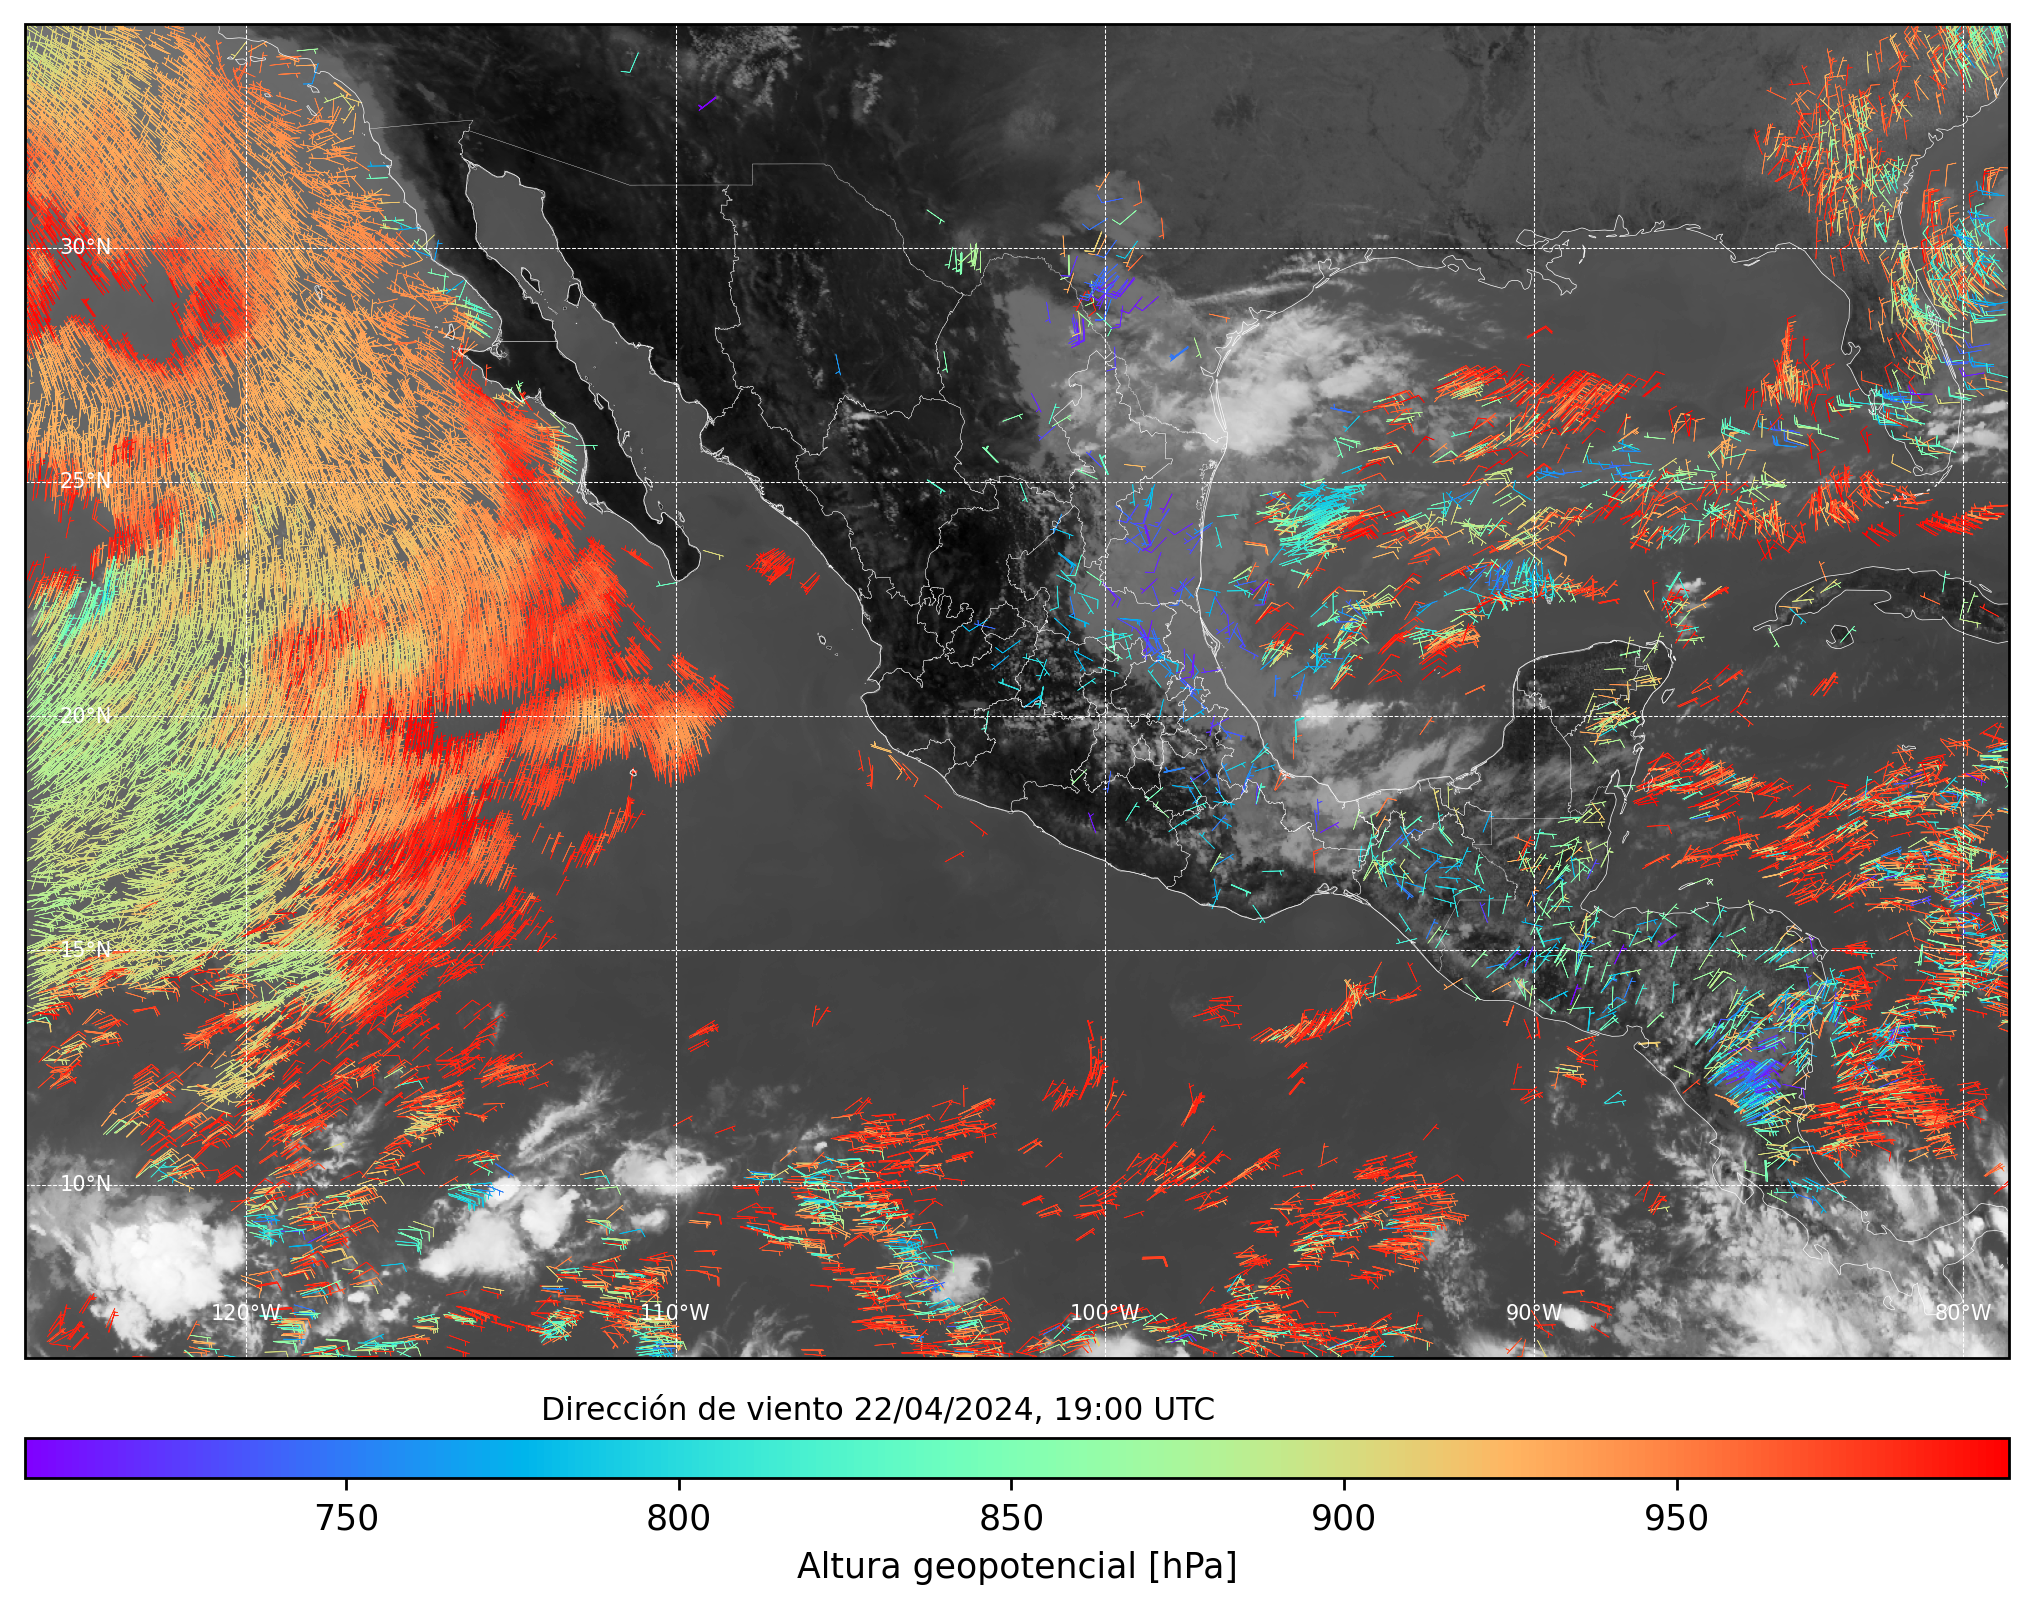

In [9]:
fig = plt.figure(figsize=(10.24,9.1), dpi=250)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=0.3,color='white',linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.ylabel_style = {'size': 6, 'color': 'white'}
gl.xlabel_style = {'size': 6, 'color': 'white'}
gl.ypadding = -10 
gl.xpadding = -10 
ax.coastlines(color='white', linewidth=0.2)
ax.imshow(ir_BT, extent=bounds,cmap="Greys")
barbs = ax.barbs(croped['lon'], croped['lat'], u, v, croped['pressure'], linewidth=0.2, length=3.5,cmap='rainbow')
axins = inset_axes(ax, width = '100%', height = '3%', loc = 'lower center', bbox_to_anchor=(0., -0.09, 1, 1), bbox_transform=ax.transAxes, borderpad=0) 

cbr = plt.colorbar(barbs, cax=axins, orientation='horizontal', extendrect=None)
cbr.set_label('Altura geopotencial [hPa]')
im=gdf.plot(ax=ax, edgecolor='white', color='none',linewidth=.1)
plt.title("Dirección de viento 22/04/2024, 19:00 UTC",fontsize = 9,x=0.43, y=0.95)